load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\re2.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\highs.dll...
load C:\Users\khatr\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\ortools.dll...
Schedule found!



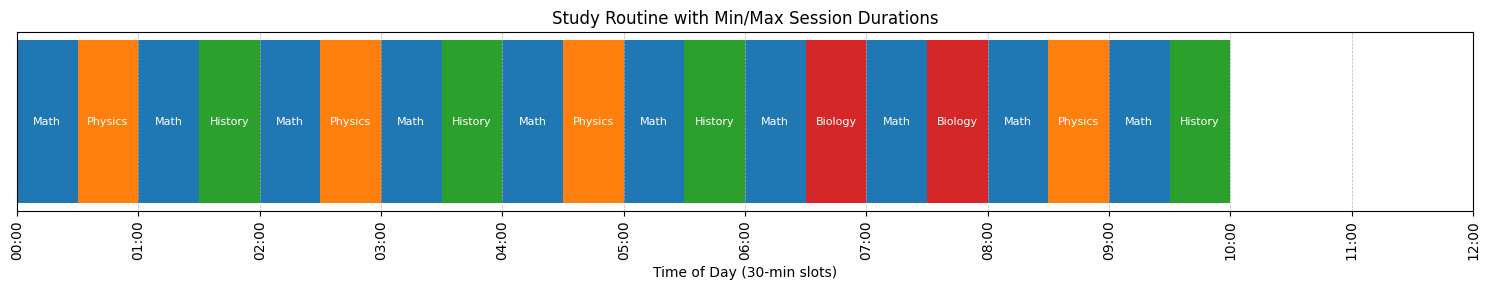

{'Math': [SubjectSession(start=Math_start_0(0..23), duration=Math_dur_0(1..2), interval=Math_interval_0(start = Math_start_0, size = Math_dur_0, end = Math_end_0, is_present = Math_active_0), is_present=Math_active_0(0..1)), SubjectSession(start=Math_start_1(0..23), duration=Math_dur_1(1..2), interval=Math_interval_1(start = Math_start_1, size = Math_dur_1, end = Math_end_1, is_present = Math_active_1), is_present=Math_active_1(0..1)), SubjectSession(start=Math_start_2(0..23), duration=Math_dur_2(1..2), interval=Math_interval_2(start = Math_start_2, size = Math_dur_2, end = Math_end_2, is_present = Math_active_2), is_present=Math_active_2(0..1)), SubjectSession(start=Math_start_3(0..23), duration=Math_dur_3(1..2), interval=Math_interval_3(start = Math_start_3, size = Math_dur_3, end = Math_end_3, is_present = Math_active_3), is_present=Math_active_3(0..1)), SubjectSession(start=Math_start_4(0..23), duration=Math_dur_4(1..2), interval=Math_interval_4(start = Math_start_4, size = Math_du

In [1]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import collections

# get the subject data with total credits
subjects_data = {
    'Math': 5,
    'Physics': 2,
    'History': 2,
    'Biology': 1
}

# calculation related to time split and total time per session

time_slot_minutes = 30
slots_per_hour = 60 // time_slot_minutes
day_duration_hours = 12
total_slots = day_duration_hours * slots_per_hour  

min_session_slots = 1  # 30 min
max_session_slots = 2  # 2 hours

# intializing the model
model = cp_model.CpModel()
all_subjects = list(subjects_data.keys())

SubjectSession = collections.namedtuple('SubjectSession', ['start', 'duration', 'interval', 'is_present'])


# creating the subject session
all_intervals = []
subject_sessions = {}

for subject in all_subjects:
    total_slots_needed = subjects_data[subject] * slots_per_hour # Total subjects per day per credits
    max_possible_sessions = total_slots_needed  # worst case: 30-min chunks

    sessions = []
    for i in range(max_possible_sessions):
        start = model.NewIntVar(0, total_slots - 1, f'{subject}_start_{i}')
        duration = model.NewIntVar(min_session_slots, max_session_slots, f'{subject}_dur_{i}')
        end = model.NewIntVar(0, total_slots, f'{subject}_end_{i}')
        is_present = model.NewBoolVar(f'{subject}_active_{i}')
        interval = model.NewOptionalIntervalVar(start, duration, end, is_present, f'{subject}_interval_{i}')
        sessions.append(SubjectSession(start, duration, interval, is_present))
        all_intervals.append(interval)
    subject_sessions[subject] = sessions

# all the constraints

# Ensure total time per subject is respected
for subject in all_subjects:
    sessions = subject_sessions[subject]
    active_durations = []
    for s in sessions:
        active = s.is_present
        active_durations.append(model.NewIntVar(0, max_session_slots, f'{subject}_active_dur'))
        model.Add(s.duration == active_durations[-1]).OnlyEnforceIf(active)
        model.Add(s.duration == 0).OnlyEnforceIf(active.Not())

    model.Add(sum(active_durations) == subjects_data[subject] * slots_per_hour)

# No overlapping sessions across all subjects
model.AddNoOverlap(all_intervals)

# No consecutive sessions of the same subject
for subject in all_subjects:
    sessions = subject_sessions[subject]
    for i in range(len(sessions)):
        for j in range(i + 1, len(sessions)):
            si, sj = sessions[i], sessions[j]
            active_both = model.NewBoolVar(f'{subject}_adj_{i}_{j}')
            model.AddBoolAnd([si.is_present, sj.is_present]).OnlyEnforceIf(active_both)
            model.AddBoolOr([si.is_present.Not(), sj.is_present.Not()]).OnlyEnforceIf(active_both.Not())
            # Add no direct adjacency
            model.Add(si.start + si.duration != sj.start).OnlyEnforceIf(active_both)

#constrain remain : skip the classes time, maximum gap between each session 


# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
status = solver.Solve(model)

# ---------------------------
# Visualization
# ---------------------------
if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    print('Schedule found!\n')
    fig, ax = plt.subplots(figsize=(15, 3))
    subject_colors = {s: f'C{i}' for i, s in enumerate(all_subjects)}
    y_pos = 5

    for subject in all_subjects:
        for s in subject_sessions[subject]:
            if solver.Value(s.is_present):
                start = solver.Value(s.start)
                duration = solver.Value(s.duration)
                ax.broken_barh([(start, duration)], (y_pos, 4), facecolors=subject_colors[subject])
                ax.text(start + duration / 2, y_pos + 2, subject, ha='center', va='center', color='white', fontsize=8)

    ax.set_xlim(0, total_slots)
    ax.set_xticks(range(0, total_slots + 1, 2))
    ax.set_xticklabels([f'{(i * time_slot_minutes) // 60:02}:{(i * time_slot_minutes) % 60:02}' for i in range(0, total_slots + 1, 2)], rotation=90)
    ax.set_yticks([])
    ax.set_title('Study Routine with Min/Max Session Durations')
    ax.set_xlabel('Time of Day (30-min slots)')
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print('No solution found.')
print(subject_sessions)
